[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ijdoc/wandb-demos/blob/main/experiments/10-train-model.ipynb)

# Model Training

## Import Libraries

In [1]:
!pip install timm
!pip install matplotlib
!pip install pandas

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm # Where the model is stored

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 (main, Sep 20 2023, 22:07:19) [Clang 15.0.0 (clang-1500.0.40.1)]
PyTorch version 2.1.0
Torchvision version 0.16.0
Numpy version 1.26.1
Pandas version 2.1.2


## Prepare Data 

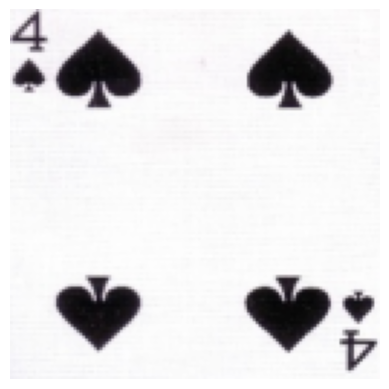


Image tensor size is: (3, 128, 128)
Image batch shape: torch.Size([32, 3, 128, 128])
Label batch shape: torch.Size([32])
Batch labels: tensor([ 6, 22, 44, 51, 44,  7,  2, 46, 29, 27, 45, 25,  8, 24, 36, 13, 51, 15,
        41, 35, 29, 39, 13, 43, 43, 50, 44, 29, 36, 11, 51, 12])


In [2]:
import random

img_size = 128

resize = transforms.Compose([
    transforms.Resize((img_size, img_size)),
])

convert = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

class PlayingCardsDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
      return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

# Load raw dataset and display an example
dataset = PlayingCardsDataset("./artifacts/playing-cards:v0/train", transform=resize)
image, label = random.choice(dataset)
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

# Load datasets as tensors
train_folder = './artifacts/playing-cards:v0/train/'
valid_folder = './artifacts/playing-cards:v0/valid/'
test_folder = './artifacts/playing-cards:v0/test/'

train_dataset = PlayingCardsDataset(train_folder, transform=convert)
val_dataset = PlayingCardsDataset(valid_folder, transform=convert)
test_dataset = PlayingCardsDataset(test_folder, transform=convert)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

image, label = random.choice(train_dataset)
print(f"\nImage tensor size is: {tuple(image.shape)}")

for images, labels in train_loader:
  break

print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")
print(f"Batch labels: {labels}")

## Prepare Model

In [3]:
num_classes = len(dataset.classes)

class CardClassifier(nn.Module):
  def __init__(self, num_classes=53):
    super(CardClassifier, self).__init__()

    # Define base model
    self.base_model = timm.create_model('efficientnet_b0', pretrained=True)

    # Remove last layer
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])
    # Keep a reference to the removed layer so we know how many connections
    # we need for the new last layer
    removed_layer = list(self.base_model.children())[-1]

    # Recreate the last layer (the classifier)
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(removed_layer.in_features, num_classes)
    )

  def forward(self, x):
    # Connect these parts and return the output
    x = self.features(x)
    return self.classifier(x)

model = CardClassifier(num_classes)
predictions = model(images)
predictions.shape  # [batch_size, num_classes]

torch.Size([32, 53])

## Training

### Setup

In [6]:
def init_training():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'Training on {device}')
    model = CardClassifier(num_classes=53)
    model.to(device)
    # Loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return device, model, loss_fn, optimizer

def learn(images, labels):
    # Move inputs and labels to the device
    images, labels = images.to(device), labels.to(device)
    # Reset optimizer gradients
    optimizer.zero_grad()
    # Predict
    outputs = model(images)
    # Calculate loss
    loss = loss_fn(outputs, labels)
    # Back-propagate
    loss.backward()
    # Optimize
    optimizer.step()
    # Return the loss for this step
    return loss.item() * labels.size(0)

def predict(images, labels):
    # Move inputs and labels to the device
    images, labels = images.to(device), labels.to(device)
    # Predict
    outputs = model(images)
    # Calculate loss
    loss = loss_fn(outputs, labels)
    # Return the loss for this step
    return loss.item() * labels.size(0)

### Loop

In [7]:
epochs = 5

device, model, loss_fn, optimizer = init_training()

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="training"):
        running_loss += learn(images, labels)
    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            running_loss += predict(images, labels)
    val_loss = running_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training on cpu


training:   0%|          | 0/239 [00:00<?, ?it/s]

KeyboardInterrupt: 